In [1]:
import random
import os
import os.path as osp
import re
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
import seaborn as sns
import pickle
import torch
import glob
from scipy.stats import entropy

pd.set_option('display.expand_frame_repr', False)  # DataFrameを改行せずに表示
pd.set_option('display.max_columns', None)  # すべての列を表示

In [2]:
def extract_finalQP(filename):
    match = re.search(r'2ndQP(\d+)', filename)
    if match:
        return int(match.group(1))
    
    match = re.search(r'1stQP(\d+)', filename)
    if match:
        return int(match.group(1))
    
    return None


def extract_1stQP(filename):
    match = re.search(r'1stQP(\d+)', filename)
    if match:
        return int(match.group(1))
    
    return None


def ratio_double_compressed(mean_difference, final_QP):
    # mean_difference = mean_difference[0]
    # final_QP = final_QP[0]
    clamped_mean_difference = np.maximum(mean_difference, -0.01)
    
    #全体のエネルギーを計算
    energy = np.sum(np.square(clamped_mean_difference))
    # energy = np.sum(np.square(mean_difference))
    
    #QP2より右側のエネルギーを計算
    right_energy = np.sum(np.square(clamped_mean_difference[final_QP+1:52]))

        
    # エネルギー比を計算して閾値と比較
    if energy > 0:
        return right_energy / energy
    
    else:
        return 0

    
def is_double_compressed(mean_difference, final_QP, threshold):
    mean_difference = mean_difference[0]
    final_QP = final_QP[0]
    clamped_mean_difference = np.maximum(mean_difference, -0.01)
    
    #全体のエネルギーを計算
    energy = np.sum(np.square(clamped_mean_difference))
    # energy = np.sum(np.square(mean_difference))
    
    #QP2より右側のエネルギーを計算
    right_energy = np.sum(np.square(clamped_mean_difference[final_QP+1:52]))
    # right_energy = np.sum(np.square(mean_difference[final_QP+1:52]))
    
    # print('energy: ', energy)
    # print('R-energy: ', right_energy)
    # print('Ratio: ', right_energy / energy)
    
    
    # エネルギー比を計算して閾値と比較
    if energy <= 0:
        return -1
    
    elif (right_energy / energy) != 0 and (right_energy / energy) > threshold:
        return True
    
    elif (right_energy / energy) != 0 and (right_energy / energy) <= threshold:
        return False
    
    else:
        return -1

def calculate_mae(file_path):
    try:
        with open(file_path, 'rb') as file:
            loaded_data, loaded_data_shifted = pickle.load(file)
    except Exception as e:
        print(f"Error occurred while loading {file_path}: {e}")
        return None

    # タプル内のリストを抽出
    original_mae = np.array(loaded_data)
    shifted_mae = np.array(loaded_data_shifted)

    # Coding ghostを計算してリストに格納する
    mae_difference = shifted_mae - original_mae
    
    # mae_differenceの各要素においてマイナスの値を0に変換
    # mae_difference_positive = np.maximum(mae_difference, 0)
    
    return mae_difference

In [3]:
rootpath_csv = "/Prove/Yoshihisa/HEIF_ghost/HEIF_IMAGES_CSV/"

train_list1 = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"]

train_list2 = ["31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50", "51", "52", "53", "54", "55", "56", "57", "58", "59", "60"]

train_list3 = ["61", "62", "63", "64", "65", "66", "67", "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78", "79", "80", "81", "82", "83", "84", "85", "86", "87", "88", "89", "90"]

train_list4 = ["91", "92", "93", "94", "95", "96", "97", "98", "99", "100", "101", "102", "103", "104", "105", "106", "107", "108", "109", "110", "111", "112", "113", "114", "115", "116", "117", "118", "119", "120"]

train_list5 = ["121", "122", "123", "124", "125", "126", "127", "128", "129", "130", "131", "132", "133", "134", "135", "136", "137", "138", "139", "140", "141", "142", "143", "144", "145", "146", "147", "148", "149", "150"]

train_list6 = ["151", "152", "153", "154", "155", "156", "157", "158", "159", "160", "161", "162", "163", "164", "165", "166", "167", "168", "169", "170", "171", "172", "173", "174", "175", "176", "177", "178", "179", "180"]

train_list7 = ["181", "182", "183", "184", "185", "186", "187", "188", "189", "190", "191", "192", "193", "194", "195", "196", "197", "198", "199", "200", "201", "202", "203", "204", "205", "206", "207", "208", "209", "210"]

train_list8 = ["211", "212", "213", "214", "215", "216", "217", "218", "219", "220", "221", "222", "223", "224", "225", "226", "227", "228", "229", "230", "231", "232", "233", "234", "235", "236", "237", "238", "239", "240"]

train_list9 = ["241", "242", "243", "244", "245", "246", "247", "248", "249", "250", "251", "252", "253", "254", "255", "256", "257", "258", "259", "260", "261", "262", "263", "264", "265", "266", "267", "268", "269", "270"]

train_list10 = ["271", "272", "273", "274", "275", "276", "277", "278", "279", "280", "281", "282", "283", "284", "285", "286", "287", "288", "289", "290", "291", "292", "293", "294", "295", "296", "297", "298", "299", "300"]


all_train_lists = [train_list1, train_list2, train_list3, train_list4, train_list5,
                   train_list6, train_list7, train_list8, train_list9, train_list10]

# すべてのリストを1つのリストに結合する
combined_train_list = sum(all_train_lists, [])

# リストの順序をランダムにシャッフルする
random.shuffle(combined_train_list)

# シャッフルされたリストを10個のグループに分割する
train_lists = [combined_train_list[i:i+30] for i in range(0, len(combined_train_list), 30)]
print(train_lists)

single_list1 = []
single_list2 = []
single_list3 = []
single_list4 = []
single_list5 = []
single_list6 = []
single_list7 = []
single_list8 = []
single_list9 = []
single_list10 = []

single_recompress_list1 = []
single_recompress_list2 = []
single_recompress_list3 = []
single_recompress_list4 = []
single_recompress_list5 = []
single_recompress_list6 = []
single_recompress_list7 = []
single_recompress_list8 = []
single_recompress_list9 = []
single_recompress_list10 = []

second_largeQP1_list1 = []
second_largeQP1_list2 = []
second_largeQP1_list3 = []
second_largeQP1_list4 = []
second_largeQP1_list5 = []
second_largeQP1_list6 = []
second_largeQP1_list7 = []
second_largeQP1_list8 = []
second_largeQP1_list9 = []
second_largeQP1_list10 = []

second_recompress_largeQP1_list1 = []
second_recompress_largeQP1_list2 = []
second_recompress_largeQP1_list3 = []
second_recompress_largeQP1_list4 = []
second_recompress_largeQP1_list5 = []
second_recompress_largeQP1_list6 = []
second_recompress_largeQP1_list7 = []
second_recompress_largeQP1_list8 = []
second_recompress_largeQP1_list9 = []
second_recompress_largeQP1_list10 = []

second_sameQP_list1 = []
second_sameQP_list2 = []
second_sameQP_list3 = []
second_sameQP_list4 = []
second_sameQP_list5 = []
second_sameQP_list6 = []
second_sameQP_list7 = []
second_sameQP_list8 = []
second_sameQP_list9 = []
second_sameQP_list10 = []

second_recompress_sameQP_list1 = []
second_recompress_sameQP_list2 = []
second_recompress_sameQP_list3 = []
second_recompress_sameQP_list4 = []
second_recompress_sameQP_list5 = []
second_recompress_sameQP_list6 = []
second_recompress_sameQP_list7 = []
second_recompress_sameQP_list8 = []
second_recompress_sameQP_list9 = []
second_recompress_sameQP_list10 = []

second_largeQP2_list1 = []
second_largeQP2_list2 = []
second_largeQP2_list3 = []
second_largeQP2_list4 = []
second_largeQP2_list5 = []
second_largeQP2_list6 = []
second_largeQP2_list7 = []
second_largeQP2_list8 = []
second_largeQP2_list9 = []
second_largeQP2_list10 = []

second_recompress_largeQP2_list1 = []
second_recompress_largeQP2_list2 = []
second_recompress_largeQP2_list3 = []
second_recompress_largeQP2_list4 = []
second_recompress_largeQP2_list5 = []
second_recompress_largeQP2_list6 = []
second_recompress_largeQP2_list7 = []
second_recompress_largeQP2_list8 = []
second_recompress_largeQP2_list9 = []
second_recompress_largeQP2_list10 = []


[['85', '44', '285', '100', '300', '135', '232', '88', '152', '261', '102', '122', '150', '259', '52', '105', '35', '138', '144', '164', '180', '223', '54', '97', '281', '250', '278', '290', '241', '225'], ['220', '80', '221', '63', '70', '65', '140', '28', '7', '75', '71', '224', '288', '95', '125', '199', '197', '212', '126', '206', '148', '270', '194', '25', '153', '142', '189', '248', '38', '208'], ['26', '243', '217', '155', '36', '141', '45', '5', '205', '127', '46', '255', '161', '267', '282', '34', '33', '293', '41', '269', '43', '218', '53', '188', '149', '186', '48', '60', '101', '39'], ['210', '247', '96', '113', '239', '6', '253', '112', '277', '294', '114', '246', '9', '258', '42', '209', '195', '109', '55', '154', '16', '286', '201', '170', '31', '37', '263', '271', '18', '237'], ['57', '2', '74', '256', '118', '49', '120', '177', '227', '124', '143', '214', '107', '235', '1', '252', '196', '238', '158', '30', '76', '181', '176', '249', '183', '157', '111', '265', '231', 

In [4]:
def process_train_lists(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list):
    
    for image in train_list:
        single_path = osp.join(rootpath_csv+f'HEIF_images_single_csv/{image}_*')
        single_recompress_path = osp.join(rootpath_csv+f'HEIF_images_second_sameQP_csv/{image}_*')
        
        second_largeQP1_path = osp.join(rootpath_csv+f'HEIF_images_second_csv/{image}_*')
        second_recompress_largeQP1_path = osp.join(rootpath_csv+f'HEIF_images_triple_csv/{image}_*')
        
        second_sameQP_path = osp.join(rootpath_csv+f'HEIF_images_second_sameQP_csv/{image}_*')
        second_recompress_sameQP_path = osp.join(rootpath_csv+f'HEIF_images_triple_sameQP_csv/{image}_*')
        
        second_largeQP2_path = osp.join(rootpath_csv+f'HEIF_images_second_largeQP_csv/{image}_*')
        second_recompress_largeQP2_path = osp.join(rootpath_csv+f'HEIF_images_triple_largeQP_csv/{image}_*')
        

        for path in sorted(glob.glob(single_path)):
            single_list.append(path)
        for path in sorted(glob.glob(single_recompress_path)):
            single_recompress_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP1_path)):
            second_largeQP1_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP1_path)):
            second_recompress_largeQP1_list.append(path)
                
        for path in sorted(glob.glob(second_sameQP_path)):
            second_sameQP_list.append(path)
        for path in sorted(glob.glob(second_recompress_sameQP_path)):
            second_recompress_sameQP_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP2_path)):
            second_largeQP2_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP2_path)):
            second_recompress_largeQP2_list.append(path)
            

# train_lists = [train_list1, train_list2, train_list3, train_list4, train_list5, train_list6, train_list7, train_list8, train_list9, train_list10]

single_lists = [single_list1, single_list2,
                single_list3, single_list4,
                single_list5, single_list6,
                single_list7, single_list8,
                single_list9, single_list10]

single_recompress_lists = [single_recompress_list1, single_recompress_list2,
                           single_recompress_list3, single_recompress_list4,
                           single_recompress_list5, single_recompress_list6,
                           single_recompress_list7, single_recompress_list8,
                           single_recompress_list9, single_recompress_list10]


second_largeQP1_lists = [second_largeQP1_list1, second_largeQP1_list2,
                        second_largeQP1_list3, second_largeQP1_list4,
                        second_largeQP1_list5, second_largeQP1_list6,
                        second_largeQP1_list7, second_largeQP1_list8,
                        second_largeQP1_list9, second_largeQP1_list10]

second_recompress_largeQP1_lists = [second_recompress_largeQP1_list1, second_recompress_largeQP1_list2,
                           second_recompress_largeQP1_list3, second_recompress_largeQP1_list4,
                           second_recompress_largeQP1_list5, second_recompress_largeQP1_list6,
                           second_recompress_largeQP1_list7, second_recompress_largeQP1_list8,
                           second_recompress_largeQP1_list9, second_recompress_largeQP1_list10]


second_sameQP_lists = [second_sameQP_list1, second_sameQP_list2,
                        second_sameQP_list3, second_sameQP_list4,
                        second_sameQP_list5, second_sameQP_list6,
                        second_sameQP_list7, second_sameQP_list8,
                        second_sameQP_list9, second_sameQP_list10]

second_recompress_sameQP_lists = [second_recompress_sameQP_list1, second_recompress_sameQP_list2,
                           second_recompress_sameQP_list3, second_recompress_sameQP_list4,
                           second_recompress_sameQP_list5, second_recompress_sameQP_list6,
                           second_recompress_sameQP_list7, second_recompress_sameQP_list8,
                           second_recompress_sameQP_list9, second_recompress_sameQP_list10]


second_largeQP2_lists = [second_largeQP2_list1, second_largeQP2_list2,
                        second_largeQP2_list3, second_largeQP2_list4,
                        second_largeQP2_list5, second_largeQP2_list6,
                        second_largeQP2_list7, second_largeQP2_list8,
                        second_largeQP2_list9, second_largeQP2_list10]

second_recompress_largeQP2_lists = [second_recompress_largeQP2_list1, second_recompress_largeQP2_list2,
                           second_recompress_largeQP2_list3, second_recompress_largeQP2_list4,
                           second_recompress_largeQP2_list5, second_recompress_largeQP2_list6,
                           second_recompress_largeQP2_list7, second_recompress_largeQP2_list8,
                           second_recompress_largeQP2_list9, second_recompress_largeQP2_list10]



for train_list, single_list, single_recompress_list, second_largeQP1_list, second_recompress_largeQP1_list, second_sameQP_list, second_recompress_sameQP_list, second_largeQP2_list, second_recompress_largeQP2_list in zip(train_lists, 
                                                                                                                                                                                                                           single_lists,
                                                                                                                                                                                                                           single_recompress_lists,
                                                                                                                                                                                                                           second_largeQP1_lists,
                                                                                                                                                                                                                           second_recompress_largeQP1_lists,
                                                                                                                                                                                                                           second_sameQP_lists,
                                                                                                                                                                                                                           second_recompress_sameQP_lists,
                                                                                                                                                                                                                           second_largeQP2_lists,
                                                                                                                                                                                                                           second_recompress_largeQP2_lists
                                                                                                                                                                                                                          ):
    process_train_lists(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list)


In [5]:
print(len(single_lists[6]))
print(len(single_recompress_lists[6]))
print(len(second_largeQP1_lists[6]))
print(len(second_recompress_largeQP1_lists[6]))
print(len(second_sameQP_lists[6]))
print(len(second_recompress_sameQP_lists[6]))
print(len(second_largeQP2_lists[6]))
print(len(second_recompress_largeQP2_lists[6]))

300
300
1710
1710
300
300
1170
1170


In [6]:
single_list1 = []
single_list2 = []
single_list3 = []
single_list4 = []
single_list5 = []
single_list6 = []
single_list7 = []
single_list8 = []
single_list9 = []
single_list10 = []

single_recompress_list1 = []
single_recompress_list2 = []
single_recompress_list3 = []
single_recompress_list4 = []
single_recompress_list5 = []
single_recompress_list6 = []
single_recompress_list7 = []
single_recompress_list8 = []
single_recompress_list9 = []
single_recompress_list10 = []

second_largeQP1_list1 = []
second_largeQP1_list2 = []
second_largeQP1_list3 = []
second_largeQP1_list4 = []
second_largeQP1_list5 = []
second_largeQP1_list6 = []
second_largeQP1_list7 = []
second_largeQP1_list8 = []
second_largeQP1_list9 = []
second_largeQP1_list10 = []

second_recompress_largeQP1_list1 = []
second_recompress_largeQP1_list2 = []
second_recompress_largeQP1_list3 = []
second_recompress_largeQP1_list4 = []
second_recompress_largeQP1_list5 = []
second_recompress_largeQP1_list6 = []
second_recompress_largeQP1_list7 = []
second_recompress_largeQP1_list8 = []
second_recompress_largeQP1_list9 = []
second_recompress_largeQP1_list10 = []

second_sameQP_list1 = []
second_sameQP_list2 = []
second_sameQP_list3 = []
second_sameQP_list4 = []
second_sameQP_list5 = []
second_sameQP_list6 = []
second_sameQP_list7 = []
second_sameQP_list8 = []
second_sameQP_list9 = []
second_sameQP_list10 = []

second_recompress_sameQP_list1 = []
second_recompress_sameQP_list2 = []
second_recompress_sameQP_list3 = []
second_recompress_sameQP_list4 = []
second_recompress_sameQP_list5 = []
second_recompress_sameQP_list6 = []
second_recompress_sameQP_list7 = []
second_recompress_sameQP_list8 = []
second_recompress_sameQP_list9 = []
second_recompress_sameQP_list10 = []

second_largeQP2_list1 = []
second_largeQP2_list2 = []
second_largeQP2_list3 = []
second_largeQP2_list4 = []
second_largeQP2_list5 = []
second_largeQP2_list6 = []
second_largeQP2_list7 = []
second_largeQP2_list8 = []
second_largeQP2_list9 = []
second_largeQP2_list10 = []

second_recompress_largeQP2_list1 = []
second_recompress_largeQP2_list2 = []
second_recompress_largeQP2_list3 = []
second_recompress_largeQP2_list4 = []
second_recompress_largeQP2_list5 = []
second_recompress_largeQP2_list6 = []
second_recompress_largeQP2_list7 = []
second_recompress_largeQP2_list8 = []
second_recompress_largeQP2_list9 = []
second_recompress_largeQP2_list10 = []

In [7]:
rootpath_pkl = "/Prove/Yoshihisa/HEIF_ghost/PKL/"


def process_train_lists2(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list):
    
    for image in train_list:
        single_path = osp.join(rootpath_pkl+f'pkl_single/{image}_*')
        single_recompress_path = osp.join(rootpath_pkl+f'pkl_second_sameQP/{image}_*')
        
        second_largeQP1_path = osp.join(rootpath_pkl+f'pkl_second/{image}_*')
        second_recompress_largeQP1_path = osp.join(rootpath_pkl+f'pkl_triple/{image}_*')
        
        second_sameQP_path = osp.join(rootpath_pkl+f'pkl_second_sameQP/{image}_*')
        second_recompress_sameQP_path = osp.join(rootpath_pkl+f'pkl_triple_sameQP/{image}_*')
        
        second_largeQP2_path = osp.join(rootpath_pkl+f'pkl_second_largeQP/{image}_*')
        second_recompress_largeQP2_path = osp.join(rootpath_pkl+f'pkl_triple_largeQP/{image}_*')
        

        for path in sorted(glob.glob(single_path)):
            single_list.append(path)
        for path in sorted(glob.glob(single_recompress_path)):
            single_recompress_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP1_path)):
            second_largeQP1_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP1_path)):
            second_recompress_largeQP1_list.append(path)
                
        for path in sorted(glob.glob(second_sameQP_path)):
            second_sameQP_list.append(path)
        for path in sorted(glob.glob(second_recompress_sameQP_path)):
            second_recompress_sameQP_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP2_path)):
            second_largeQP2_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP2_path)):
            second_recompress_largeQP2_list.append(path)
            

# train_lists = [train_list1, train_list2, train_list3, train_list4, train_list5, train_list6, train_list7, train_list8, train_list9, train_list10]

single_listsA = [single_list1, single_list2,
                single_list3, single_list4,
                single_list5, single_list6,
                single_list7, single_list8,
                single_list9, single_list10]

single_recompress_listsA = [single_recompress_list1, single_recompress_list2,
                           single_recompress_list3, single_recompress_list4,
                           single_recompress_list5, single_recompress_list6,
                           single_recompress_list7, single_recompress_list8,
                           single_recompress_list9, single_recompress_list10]


second_largeQP1_listsA = [second_largeQP1_list1, second_largeQP1_list2,
                        second_largeQP1_list3, second_largeQP1_list4,
                        second_largeQP1_list5, second_largeQP1_list6,
                        second_largeQP1_list7, second_largeQP1_list8,
                        second_largeQP1_list9, second_largeQP1_list10]

second_recompress_largeQP1_listsA = [second_recompress_largeQP1_list1, second_recompress_largeQP1_list2,
                           second_recompress_largeQP1_list3, second_recompress_largeQP1_list4,
                           second_recompress_largeQP1_list5, second_recompress_largeQP1_list6,
                           second_recompress_largeQP1_list7, second_recompress_largeQP1_list8,
                           second_recompress_largeQP1_list9, second_recompress_largeQP1_list10]


second_sameQP_listsA = [second_sameQP_list1, second_sameQP_list2,
                        second_sameQP_list3, second_sameQP_list4,
                        second_sameQP_list5, second_sameQP_list6,
                        second_sameQP_list7, second_sameQP_list8,
                        second_sameQP_list9, second_sameQP_list10]

second_recompress_sameQP_listsA = [second_recompress_sameQP_list1, second_recompress_sameQP_list2,
                           second_recompress_sameQP_list3, second_recompress_sameQP_list4,
                           second_recompress_sameQP_list5, second_recompress_sameQP_list6,
                           second_recompress_sameQP_list7, second_recompress_sameQP_list8,
                           second_recompress_sameQP_list9, second_recompress_sameQP_list10]


second_largeQP2_listsA = [second_largeQP2_list1, second_largeQP2_list2,
                        second_largeQP2_list3, second_largeQP2_list4,
                        second_largeQP2_list5, second_largeQP2_list6,
                        second_largeQP2_list7, second_largeQP2_list8,
                        second_largeQP2_list9, second_largeQP2_list10]

second_recompress_largeQP2_listsA = [second_recompress_largeQP2_list1, second_recompress_largeQP2_list2,
                           second_recompress_largeQP2_list3, second_recompress_largeQP2_list4,
                           second_recompress_largeQP2_list5, second_recompress_largeQP2_list6,
                           second_recompress_largeQP2_list7, second_recompress_largeQP2_list8,
                           second_recompress_largeQP2_list9, second_recompress_largeQP2_list10]



for train_list, single_list, single_recompress_list, second_largeQP1_list, second_recompress_largeQP1_list, second_sameQP_list, second_recompress_sameQP_list, second_largeQP2_list, second_recompress_largeQP2_list in zip(train_lists, 
                                                                                                                                                                                                                           single_listsA,
                                                                                                                                                                                                                           single_recompress_listsA,
                                                                                                                                                                                                                           second_largeQP1_listsA,
                                                                                                                                                                                                                           second_recompress_largeQP1_listsA,
                                                                                                                                                                                                                           second_sameQP_listsA,
                                                                                                                                                                                                                           second_recompress_sameQP_listsA,
                                                                                                                                                                                                                           second_largeQP2_listsA,
                                                                                                                                                                                                                           second_recompress_largeQP2_listsA
                                                                                                                                                                                                                          ):
    process_train_lists2(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list)

In [8]:
print(len(single_listsA[6]))
print(len(single_recompress_listsA[6]))
print(len(second_largeQP1_listsA[6]))
print(len(second_recompress_largeQP1_listsA[6]))
print(len(second_sameQP_listsA[6]))
print(len(second_recompress_sameQP_listsA[6]))
print(len(second_largeQP2_listsA[6]))
print(len(second_recompress_largeQP2_listsA[6]))

300
300
1710
1710
300
300
1170
1170


In [9]:
single_csv1 = list(zip(single_lists[0], single_listsA[0], single_recompress_lists[0], single_recompress_listsA[0]))
single_csv2 = list(zip(single_lists[1], single_listsA[1], single_recompress_lists[1], single_recompress_listsA[1]))
single_csv3 = list(zip(single_lists[2], single_listsA[2], single_recompress_lists[2], single_recompress_listsA[2]))
single_csv4 = list(zip(single_lists[3], single_listsA[3], single_recompress_lists[3], single_recompress_listsA[3]))
single_csv5 = list(zip(single_lists[4], single_listsA[4], single_recompress_lists[4], single_recompress_listsA[4]))
single_csv6 = list(zip(single_lists[5], single_listsA[5], single_recompress_lists[5], single_recompress_listsA[5]))
single_csv7 = list(zip(single_lists[6], single_listsA[6], single_recompress_lists[6], single_recompress_listsA[6]))
single_csv8 = list(zip(single_lists[7], single_listsA[7], single_recompress_lists[7], single_recompress_listsA[7]))
single_csv9 = list(zip(single_lists[8], single_listsA[8], single_recompress_lists[8], single_recompress_listsA[8]))
single_csv10 = list(zip(single_lists[9], single_listsA[9], single_recompress_lists[9], single_recompress_listsA[9]))
print(len(single_csv7))

second_largeQP1_csv1 = list(zip(second_largeQP1_lists[0], second_largeQP1_listsA[0], second_recompress_largeQP1_lists[0], second_recompress_largeQP1_listsA[0]))
second_largeQP1_csv2 = list(zip(second_largeQP1_lists[1], second_largeQP1_listsA[1], second_recompress_largeQP1_lists[1], second_recompress_largeQP1_listsA[1]))
second_largeQP1_csv3 = list(zip(second_largeQP1_lists[2], second_largeQP1_listsA[2], second_recompress_largeQP1_lists[2], second_recompress_largeQP1_listsA[2]))
second_largeQP1_csv4 = list(zip(second_largeQP1_lists[3], second_largeQP1_listsA[3], second_recompress_largeQP1_lists[3], second_recompress_largeQP1_listsA[3]))
second_largeQP1_csv5 = list(zip(second_largeQP1_lists[4], second_largeQP1_listsA[4], second_recompress_largeQP1_lists[4], second_recompress_largeQP1_listsA[4]))
second_largeQP1_csv6 = list(zip(second_largeQP1_lists[5], second_largeQP1_listsA[5], second_recompress_largeQP1_lists[5], second_recompress_largeQP1_listsA[5]))
second_largeQP1_csv7 = list(zip(second_largeQP1_lists[6], second_largeQP1_listsA[6], second_recompress_largeQP1_lists[6], second_recompress_largeQP1_listsA[6]))
second_largeQP1_csv8 = list(zip(second_largeQP1_lists[7], second_largeQP1_listsA[7], second_recompress_largeQP1_lists[7], second_recompress_largeQP1_listsA[7]))
second_largeQP1_csv9 = list(zip(second_largeQP1_lists[8], second_largeQP1_listsA[8], second_recompress_largeQP1_lists[8], second_recompress_largeQP1_listsA[8]))
second_largeQP1_csv10 = list(zip(second_largeQP1_lists[9], second_largeQP1_listsA[9], second_recompress_largeQP1_lists[9], second_recompress_largeQP1_listsA[9]))

second_largeQP1_csv1 = random.sample(second_largeQP1_csv1, 100)
second_largeQP1_csv2 = random.sample(second_largeQP1_csv2, 100)
second_largeQP1_csv3 = random.sample(second_largeQP1_csv3, 100)
second_largeQP1_csv4 = random.sample(second_largeQP1_csv4, 100)
second_largeQP1_csv5 = random.sample(second_largeQP1_csv5, 100)
second_largeQP1_csv6 = random.sample(second_largeQP1_csv6, 100)
second_largeQP1_csv7 = random.sample(second_largeQP1_csv7, 100)
second_largeQP1_csv8 = random.sample(second_largeQP1_csv8, 100)
second_largeQP1_csv9 = random.sample(second_largeQP1_csv9, 100)
second_largeQP1_csv10 = random.sample(second_largeQP1_csv10, 100)
print(len(second_largeQP1_csv7))

second_sameQP_csv1 = list(zip(second_sameQP_lists[0], second_sameQP_listsA[0], second_recompress_sameQP_lists[0], second_recompress_sameQP_listsA[0]))
second_sameQP_csv2 = list(zip(second_sameQP_lists[1], second_sameQP_listsA[1], second_recompress_sameQP_lists[1], second_recompress_sameQP_listsA[1]))
second_sameQP_csv3 = list(zip(second_sameQP_lists[2], second_sameQP_listsA[2], second_recompress_sameQP_lists[2], second_recompress_sameQP_listsA[2]))
second_sameQP_csv4 = list(zip(second_sameQP_lists[3], second_sameQP_listsA[3], second_recompress_sameQP_lists[3], second_recompress_sameQP_listsA[3]))
second_sameQP_csv5 = list(zip(second_sameQP_lists[4], second_sameQP_listsA[4], second_recompress_sameQP_lists[4], second_recompress_sameQP_listsA[4]))
second_sameQP_csv6 = list(zip(second_sameQP_lists[5], second_sameQP_listsA[5], second_recompress_sameQP_lists[5], second_recompress_sameQP_listsA[5]))
second_sameQP_csv7 = list(zip(second_sameQP_lists[6], second_sameQP_listsA[6], second_recompress_sameQP_lists[6], second_recompress_sameQP_listsA[6]))
second_sameQP_csv8 = list(zip(second_sameQP_lists[7], second_sameQP_listsA[7], second_recompress_sameQP_lists[7], second_recompress_sameQP_listsA[7]))
second_sameQP_csv9 = list(zip(second_sameQP_lists[8], second_sameQP_listsA[8], second_recompress_sameQP_lists[8], second_recompress_sameQP_listsA[8]))
second_sameQP_csv10 = list(zip(second_sameQP_lists[9], second_sameQP_listsA[9], second_recompress_sameQP_lists[9], second_recompress_sameQP_listsA[9]))

second_sameQP_csv1 = random.sample(second_sameQP_csv1, 100)
second_sameQP_csv2 = random.sample(second_sameQP_csv2, 100)
second_sameQP_csv3 = random.sample(second_sameQP_csv3, 100)
second_sameQP_csv4 = random.sample(second_sameQP_csv4, 100)
second_sameQP_csv5 = random.sample(second_sameQP_csv5, 100)
second_sameQP_csv6 = random.sample(second_sameQP_csv6, 100)
second_sameQP_csv7 = random.sample(second_sameQP_csv7, 100)
second_sameQP_csv8 = random.sample(second_sameQP_csv8, 100)
second_sameQP_csv9 = random.sample(second_sameQP_csv9, 100)
second_sameQP_csv10 = random.sample(second_sameQP_csv10, 100)
print(len(second_sameQP_csv7))

second_largeQP2_csv1 = list(zip(second_largeQP2_lists[0], second_largeQP2_listsA[0], second_recompress_largeQP2_lists[0], second_recompress_largeQP2_listsA[0]))
second_largeQP2_csv2 = list(zip(second_largeQP2_lists[1], second_largeQP2_listsA[1], second_recompress_largeQP2_lists[1], second_recompress_largeQP2_listsA[1]))
second_largeQP2_csv3 = list(zip(second_largeQP2_lists[2], second_largeQP2_listsA[2], second_recompress_largeQP2_lists[2], second_recompress_largeQP2_listsA[2]))
second_largeQP2_csv4 = list(zip(second_largeQP2_lists[3], second_largeQP2_listsA[3], second_recompress_largeQP2_lists[3], second_recompress_largeQP2_listsA[3]))
second_largeQP2_csv5 = list(zip(second_largeQP2_lists[4], second_largeQP2_listsA[4], second_recompress_largeQP2_lists[4], second_recompress_largeQP2_listsA[4]))
second_largeQP2_csv6 = list(zip(second_largeQP2_lists[5], second_largeQP2_listsA[5], second_recompress_largeQP2_lists[5], second_recompress_largeQP2_listsA[5]))
second_largeQP2_csv7 = list(zip(second_largeQP2_lists[6], second_largeQP2_listsA[6], second_recompress_largeQP2_lists[6], second_recompress_largeQP2_listsA[6]))
second_largeQP2_csv8 = list(zip(second_largeQP2_lists[7], second_largeQP2_listsA[7], second_recompress_largeQP2_lists[7], second_recompress_largeQP2_listsA[7]))
second_largeQP2_csv9 = list(zip(second_largeQP2_lists[8], second_largeQP2_listsA[8], second_recompress_largeQP2_lists[8], second_recompress_largeQP2_listsA[8]))
second_largeQP2_csv10 = list(zip(second_largeQP2_lists[9], second_largeQP2_listsA[9], second_recompress_largeQP2_lists[9], second_recompress_largeQP2_listsA[9]))

second_largeQP2_csv1 = random.sample(second_largeQP2_csv1, 100)
second_largeQP2_csv2 = random.sample(second_largeQP2_csv2, 100)
second_largeQP2_csv3 = random.sample(second_largeQP2_csv3, 100)
second_largeQP2_csv4 = random.sample(second_largeQP2_csv4, 100)
second_largeQP2_csv5 = random.sample(second_largeQP2_csv5, 100)
second_largeQP2_csv6 = random.sample(second_largeQP2_csv6, 100)
second_largeQP2_csv7 = random.sample(second_largeQP2_csv7, 100)
second_largeQP2_csv8 = random.sample(second_largeQP2_csv8, 100)
second_largeQP2_csv9 = random.sample(second_largeQP2_csv9, 100)
second_largeQP2_csv10 = random.sample(second_largeQP2_csv10, 100)
print(len(second_largeQP2_csv7))


train_csv_list1 = single_csv1 + second_largeQP1_csv1 + second_sameQP_csv1 + second_largeQP2_csv1
train_csv_list2 = single_csv2 + second_largeQP1_csv2 + second_sameQP_csv2 + second_largeQP2_csv2
train_csv_list3 = single_csv3 + second_largeQP1_csv3 + second_sameQP_csv3 + second_largeQP2_csv3
train_csv_list4 = single_csv4 + second_largeQP1_csv4 + second_sameQP_csv4 + second_largeQP2_csv4
train_csv_list5 = single_csv5 + second_largeQP1_csv5 + second_sameQP_csv5 + second_largeQP2_csv5
train_csv_list6 = single_csv6 + second_largeQP1_csv6 + second_sameQP_csv6 + second_largeQP2_csv6
train_csv_list7 = single_csv7 + second_largeQP1_csv7 + second_sameQP_csv7 + second_largeQP2_csv7
train_csv_list8 = single_csv8 + second_largeQP1_csv8 + second_sameQP_csv8 + second_largeQP2_csv8
train_csv_list9 = single_csv9 + second_largeQP1_csv9 + second_sameQP_csv9 + second_largeQP2_csv9
train_csv_list10 = single_csv10 + second_largeQP1_csv10 + second_sameQP_csv10 + second_largeQP2_csv10

print("train_csv_list: ", len(train_csv_list7))

300
100
100
100
train_csv_list:  600


In [10]:
def laplace_smoothing(probabilities, alpha=1):
    """
    ラプラス平滑化を行う関数
    
    Args:
    probabilities (list): 平滑化する確率分布のリスト
    alpha (float): 平滑化パラメータ
    
    Returns:
    smoothed_probabilities (list): 平滑化された確率分布のリスト
    """
    total_count = sum(probabilities)
    num_elements = len(probabilities)
    
    smoothed_probabilities = [(count + alpha) / (total_count + alpha * num_elements) for count in probabilities]
    
    return smoothed_probabilities




def process_train_csv_lists(train_csv_list):
    pu_columns = ["PU1_64", "PU1_32", "PU1_16", "PU1_8", "PU1_4",  
                  "PU2_64","PU2_32", "PU2_16", "PU2_8", "PU2_4"]

#     luminance_columns = ["LU1_0","LU1_1","LU1_2","LU1_3",
#                          "LU1_4","LU1_5","LU1_6","LU1_7",
#                          "LU1_8","LU1_9","LU1_10","LU1_11",
#                          "LU1_12","LU1_13","LU1_14","LU1_15",
#                          "LU1_16","LU1_17","LU1_18","LU1_19",
#                          "LU1_20","LU1_21","LU1_22","LU1_23",
#                          "LU1_24","LU1_25","LU1_26","LU1_27",
#                          "LU1_28","LU1_29","LU1_30","LU1_31",
#                          "LU1_32","LU1_33","LU1_34",
                         
#                          "LU2_0","LU2_1","LU2_2","LU2_3",
#                          "LU2_4","LU2_5","LU2_6","LU2_7",
#                          "LU2_8","LU2_9","LU2_10","LU2_11",
#                          "LU2_12","LU2_13","LU2_14","LU2_15",
#                          "LU2_16","LU2_17","LU2_18","LU2_19",
#                          "LU2_20","LU2_21","LU2_22","LU2_23",
#                          "LU2_24","LU2_25","LU2_26","LU2_27",
#                          "LU2_28","LU2_29","LU2_30","LU2_31",
#                          "LU2_32","LU2_33","LU2_34"]
    
    luminance_columns = ["LU1_0","LU1_1","LU1_9","LU1_10","LU1_11","LU1_25","LU1_26","LU1_27",
                         "LU2_0","LU2_1","LU2_9","LU2_10","LU2_11", "LU2_25","LU2_26","LU2_27"]

    chrominance_columns = ["CH1_0", "CH1_1", "CH1_10", "CH1_26", "CH1_34", "CH1_36", 
                           "CH2_0", "CH2_1", "CH2_10", "CH2_26", "CH2_34", "CH2_36"]
    
    
    
    label_columns = ["LABEL"]
    mae1_columns = [f"MAE1_{i}" for i in range(52)]
    mae2_columns = [f"MAE2_{i}" for i in range(52)]
    mae_columns = ["MAE"]
    final_qp_columns = ["FINAL_QP"]
    kl_divergence1 = ["KLD_PU"]
    kl_divergence2 = ["KLD_LUMA"]
    kl_divergence3 = ["KLD_CHROMA"]
    ratio_columns1 = ["RATIO1"]
    ratio_columns2 = ["RATIO2"]
    
    train_df1_1 = pd.DataFrame(columns=pu_columns)
    train_df1_2 = pd.DataFrame(columns=luminance_columns)
    train_df1_3 = pd.DataFrame(columns=chrominance_columns)
    LABEL = pd.DataFrame(columns=label_columns)
    RATIO1 = pd.DataFrame(columns=ratio_columns1)
    RATIO2 = pd.DataFrame(columns=ratio_columns2)
    train_df3 = pd.DataFrame(columns=mae1_columns)
    train_df4 = pd.DataFrame(columns=mae2_columns)
    MAE = pd.DataFrame(columns=mae_columns)
    FINAL_QP = pd.DataFrame(columns=final_qp_columns)
    kl_divergence_df1 = pd.DataFrame(columns=kl_divergence1)
    kl_divergence_df2 = pd.DataFrame(columns=kl_divergence2)
    kl_divergence_df3 = pd.DataFrame(columns=kl_divergence3)

    for path1, path2, path3, path4 in train_csv_list:
        label = 1 if ("2ndQP" in path1) and ("3rdQP" in path3) else 0
        train_pkl_list = [path2, path4]
        df1 = pd.read_csv(path1)
        df2 = pd.read_csv(path3)
        
        # 平滑化を行う
        probabilities_df1 = laplace_smoothing([df1.loc[i, "pu_counts"] for i in [0,1,2,3,4]])
        probabilities_df2 = laplace_smoothing([df2.loc[i, "pu_counts"] for i in [0,1,2,3,4]])
        kl_divergence1 = entropy(probabilities_df1, probabilities_df2)
        
        probabilities_df3 = laplace_smoothing([df1.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]])
        probabilities_df4 = laplace_smoothing([df2.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]])
        kl_divergence2 = entropy(probabilities_df3, probabilities_df4)
        
        probabilities_df5 = laplace_smoothing([df1.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]])
        probabilities_df6 = laplace_smoothing([df2.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]])
        kl_divergence3 = entropy(probabilities_df5, probabilities_df6)
        
        
        pu_values = [df1.loc[i, "pu_counts"] for i in range(5)] + [df2.loc[i, "pu_counts"] for i in range(5)]
        # lu_values = [df1.loc[i, "luminance_counts"] for i in range(35)] + [df2.loc[i, "luminance_counts"] for i in range(35)]
        lu_values = [df1.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]] + [df2.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]]
        ch_values = [df1.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]] + [df2.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]]
        
        train_df1_1 = pd.concat([train_df1_1, pd.DataFrame([pu_values], columns=pu_columns)], ignore_index=True)
        train_df1_2= pd.concat([train_df1_2, pd.DataFrame([lu_values], columns=luminance_columns)], ignore_index=True)
        train_df1_3 = pd.concat([train_df1_3, pd.DataFrame([ch_values], columns=chrominance_columns)], ignore_index=True)
        
        kl_divergence_df1 = pd.concat([kl_divergence_df1, pd.DataFrame({"KLD_PU": [kl_divergence1]})], ignore_index=True)
        kl_divergence_df2 = pd.concat([kl_divergence_df2, pd.DataFrame({"KLD_LUMA": [kl_divergence2]})], ignore_index=True)
        kl_divergence_df3 = pd.concat([kl_divergence_df3, pd.DataFrame({"KLD_CHROMA": [kl_divergence3]})], ignore_index=True)


        LABEL = pd.concat([LABEL, pd.DataFrame({"LABEL": [label]})], ignore_index=True)

        final_QP = extract_finalQP(train_pkl_list[0])

        mae_d1 = calculate_mae(train_pkl_list[0])
        mae_d2 = calculate_mae(train_pkl_list[1])
        ratio1 = ratio_double_compressed(mae_d1, final_QP)
        ratio2 = ratio_double_compressed(mae_d2, final_QP)

        RATIO1 = pd.concat([RATIO1, pd.DataFrame({"RATIO1": [ratio1]})], ignore_index=True)
        RATIO2 = pd.concat([RATIO2, pd.DataFrame({"RATIO2": [ratio2]})], ignore_index=True)

        train_df3 = pd.concat([train_df3, pd.DataFrame({f"MAE1_{i}": [mae_d1[i]] for i in range(52)})], ignore_index=True)
        train_df4 = pd.concat([train_df4, pd.DataFrame({f"MAE2_{i}": [mae_d2[i]] for i in range(52)})], ignore_index=True)
        MAE = pd.concat([MAE, pd.DataFrame({"MAE": [mae_d1]})], ignore_index=True)
        FINAL_QP = pd.concat([FINAL_QP, pd.DataFrame({"FINAL_QP": [final_QP]})], ignore_index=True)

    train_df1_1.reset_index(drop=True, inplace=True)
    train_df1_2.reset_index(drop=True, inplace=True)
    train_df1_3.reset_index(drop=True, inplace=True)
    LABEL.reset_index(drop=True, inplace=True)
    RATIO1.reset_index(drop=True, inplace=True)
    RATIO2.reset_index(drop=True, inplace=True)
    kl_divergence_df1.reset_index(drop=True, inplace=True)
    kl_divergence_df2.reset_index(drop=True, inplace=True)
    kl_divergence_df3.reset_index(drop=True, inplace=True)

    # train_df = pd.concat([train_df1_1, train_df1_2, train_df1_3, train_df3, train_df4], axis=1)
    train_df = pd.concat([FINAL_QP, kl_divergence_df1, kl_divergence_df2, kl_divergence_df3, RATIO1, RATIO2], axis=1)
    train_df_onlyGhost = pd.concat([train_df3, train_df4], axis=1)

    return train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP


In [11]:
train_df1, train_df_onlyGhost1, LABEL1, MAE1, FINAL_QP1 = process_train_csv_lists(train_csv_list1)
train_df2, train_df_onlyGhost2, LABEL2, MAE2, FINAL_QP2 = process_train_csv_lists(train_csv_list2)
train_df3, train_df_onlyGhost3, LABEL3, MAE3, FINAL_QP3 = process_train_csv_lists(train_csv_list3)
train_df4, train_df_onlyGhost4, LABEL4, MAE4, FINAL_QP4 = process_train_csv_lists(train_csv_list4)
train_df5, train_df_onlyGhost5, LABEL5, MAE5, FINAL_QP5 = process_train_csv_lists(train_csv_list5)
train_df6, train_df_onlyGhost6, LABEL6, MAE6, FINAL_QP6 = process_train_csv_lists(train_csv_list6)
train_df7, train_df_onlyGhost7, LABEL7, MAE7, FINAL_QP7 = process_train_csv_lists(train_csv_list7)
train_df8, train_df_onlyGhost8, LABEL8, MAE8, FINAL_QP8 = process_train_csv_lists(train_csv_list8)
train_df9, train_df_onlyGhost9, LABEL9, MAE9, FINAL_QP9 = process_train_csv_lists(train_csv_list9)
train_df10, train_df_onlyGhost10, LABEL10, MAE10, FINAL_QP10 = process_train_csv_lists(train_csv_list10)

In [12]:
print(train_df1)

    FINAL_QP    KLD_PU  KLD_LUMA KLD_CHROMA    RATIO1    RATIO2
0         10  0.000185  0.001792   0.000589  0.087446  0.053048
1         16  0.000016  0.000528   0.001403  0.038391  0.024025
2         20   0.00024  0.001576   0.000509  0.054873  0.025453
3         24  0.000033  0.000621   0.000436  0.151288  0.128411
4         27  0.000027  0.001466   0.000748  0.155327  0.149806
..       ...       ...       ...        ...       ...       ...
595       45  0.002191  0.004622   0.005431  0.127585  0.153551
596       16  0.000066  0.000272   0.000354  0.082588  0.032958
597       27   0.00055  0.001877   0.002965  0.227308   0.18078
598       39  0.000153  0.002371   0.011245  0.159498  0.165965
599       39  0.001478  0.004967   0.003003   0.14416   0.14397

[600 rows x 6 columns]


In [13]:
def process_results_to_lists(train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP):
    scaler = MinMaxScaler()

    # スケーラーを使って結合したデータをスケーリング
    X_train = scaler.fit_transform(train_df)
    X_train_onlyGhost = scaler.fit_transform(train_df_onlyGhost)

    # pandasをndarrayに変換
    MAE_array = MAE.values
    FINAL_QP_array = FINAL_QP.values

    # ラベルの準備
    Y_train = LABEL['LABEL'].astype(int)

    return X_train, X_train_onlyGhost, MAE_array, FINAL_QP_array, Y_train

def append_results_to_lists(train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP,
                            X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list):
    X_train, X_train_onlyGhost, MAE_array, FINAL_QP_array, Y_train = process_results_to_lists(train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP)
    X_train_list.append(X_train)
    X_train_onlyGhost_list.append(X_train_onlyGhost)
    MAE_list.append(MAE_array)
    FINAL_QP_list.append(FINAL_QP_array)
    Y_train_list.append(Y_train)

# リストを初期化
X_train_list = []
X_train_onlyGhost_list = []
MAE_list = []
FINAL_QP_list = []
Y_train_list = []

# データを処理してリストに追加
append_results_to_lists(train_df1, train_df_onlyGhost1, LABEL1, MAE1, FINAL_QP1, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df2, train_df_onlyGhost2, LABEL2, MAE2, FINAL_QP2, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df3, train_df_onlyGhost3, LABEL3, MAE3, FINAL_QP3, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df4, train_df_onlyGhost4, LABEL4, MAE4, FINAL_QP4, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df5, train_df_onlyGhost5, LABEL5, MAE5, FINAL_QP5, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df6, train_df_onlyGhost6, LABEL6, MAE6, FINAL_QP6, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df7, train_df_onlyGhost7, LABEL7, MAE7, FINAL_QP7, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df8, train_df_onlyGhost8, LABEL8, MAE8, FINAL_QP8, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df9, train_df_onlyGhost9, LABEL9, MAE9, FINAL_QP9, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df10, train_df_onlyGhost10, LABEL10, MAE10, FINAL_QP10, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)

In [14]:
# 各リストの長さを確認
# print(len(X_train_list))
# print((X_train_onlyGhost_list[0])[0])
# print((MAE_list[0])[0])
# print((FINAL_QP_list[0])[0])
# print((Y_train_list[0])[0])

In [15]:
# Cの範囲を指定
C_values = {'C': [0.01, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000]}
# C_values = {'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]}
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# 結果のデータフレームを初期化
results = pd.DataFrame(columns=['C_RBF', 'Score_RBF', 'tnr_rbf', 'tpr_rbf',
                                'C_LINEAR', 'Score_LINEAR', 'tnr_linear', 'tpr_linear',
                                'C_OG_RBF', 'Score_OG_RBF', 'tnr_og_rbf', 'tpr_og_rbf',
                                'C_OG_LINEAR', 'Score_OG_LINEAR', 'tnr_og_linear', 'tpr_og_linear',
                                'Threshold', 'Score_old', 'tnr_old', 'tpr_old'])
    
X_index = np.arange(10)  # インデックスとして0から9までの数字を用意

# ループで各分割のtrain_idsとtest_idsを取得
for fold, (train_ids, test_ids) in enumerate(kfold.split(X_index)):
    print(f"<Fold-{fold+1}>")
    print("Train indices:", train_ids)
    print("Test indices:", test_ids)
        
    test_data = [X_train_list[i] for i in test_ids]
    test_data_OG = [X_train_onlyGhost_list[i] for i in test_ids]
    test_label = [Y_train_list[i] for i in test_ids]
    
    train_data = [X_train_list[i] for i in train_ids]
    train_data_OG = [X_train_onlyGhost_list[i] for i in train_ids]
    train_label = [Y_train_list[i] for i in train_ids]
    
    
    train_data = [item for data in train_data for item in data]
    train_data_OG = [item for data in train_data_OG for item in data]
    train_label = [item for data in train_label for item in data]
    
    X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_label, test_size=600, random_state=42)
    X_train_OG, X_val_OG, _, _ = train_test_split(train_data_OG, train_label, test_size=600, random_state=42)
    
    test_data = [item for data in test_data for item in data]
    test_data_OG = [item for data in test_data_OG for item in data]
    test_label = [item for data in test_label for item in data]

    MAE_data = [MAE_list[i] for i in test_ids]
    MAE_data = [item for data in MAE_data for item in data]
    
    FINAL_QP_data = [FINAL_QP_list[i] for i in test_ids]
    FINAL_QP_data = [item for data in FINAL_QP_data for item in data]
    
    # print(len(test_data))
    # print(len(test_data_OG))
    # print(len(test_label))    
    # print(len(X_train))
    # print(len(X_val))
    # print(len(X_train_OG))
    # print(len(X_val_OG))
    # print(len(Y_train))
    # print(len(Y_val))
    # print(len(MAE_data))
    # print(len(FINAL_QP_data))
                                                                                             
    best_threshold = 0
    best_accuracy = 0
    best_predicted_labels = []
    best_ground_truth_labels = []
                
    for threshold in np.arange(0.01, 1.00, 0.01):
        results_old = np.array([is_double_compressed(MAE_data[i], FINAL_QP_data[i], threshold) for i in range(600)])
        predicted_labels = results_old.astype(int)
        ground_truth_labels = np.array(test_label)
        accuracy = np.sum(ground_truth_labels == predicted_labels) / len(ground_truth_labels)
    
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
            best_predicted_labels = predicted_labels
            best_ground_truth_labels = ground_truth_labels
    
    best_val_score_RBF, best_svm_model_RBF, best_c_value_RBF = 0, None, None
    best_val_score_onlyGhost_RBF, best_svm_model_onlyGhost_RBF, best_c_value_onlyGhost_RBF = 0, None, None
    
    best_val_score_LINEAR, best_svm_model_LINEAR, best_c_value_LINEAR = 0, None, None
    best_val_score_onlyGhost_LINEAR, best_svm_model_onlyGhost_LINEAR, best_c_value_onlyGhost_LINEAR = 0, None, None
        
    for C_value in C_values['C']:    
        # SVMモデルのインスタンスを作成
        svm_model_RBF = SVC(kernel='rbf', C=C_value)
        svm_model_onlyGhost_RBF = SVC(kernel='rbf', C=C_value)
        
        svm_model_LINEAR = SVC(kernel='linear', C=C_value)
        svm_model_onlyGhost_LINEAR = SVC(kernel='linear', C=C_value)

        # 訓練データで訓練
        svm_model_RBF.fit(X_train, Y_train)
        svm_model_onlyGhost_RBF.fit(X_train_OG, Y_train)
        
        svm_model_LINEAR.fit(X_train, Y_train)
        svm_model_onlyGhost_LINEAR.fit(X_train_OG, Y_train)

        
        val_accuracy_RBF = accuracy_score(Y_val, svm_model_RBF.predict(X_val))
        val_accuracy_onlyGhost_RBF = accuracy_score(Y_val, svm_model_onlyGhost_RBF.predict(X_val_OG))
        
        val_accuracy_LINEAR = accuracy_score(Y_val, svm_model_LINEAR.predict(X_val))
        val_accuracy_onlyGhost_LINEAR = accuracy_score(Y_val, svm_model_onlyGhost_LINEAR.predict(X_val_OG))
        

        # 検証データでの精度が最も高かった場合、そのモデルを保存
        if val_accuracy_RBF > best_val_score_RBF:
            best_val_score_RBF, best_svm_model_RBF, best_c_value_RBF = val_accuracy_RBF, svm_model_RBF, C_value

        if val_accuracy_onlyGhost_RBF > best_val_score_onlyGhost_RBF:
            best_val_score_onlyGhost_RBF, best_svm_model_onlyGhost_RBF, best_c_value_onlyGhost_RBF = val_accuracy_onlyGhost_RBF, svm_model_onlyGhost_RBF, C_value
            
        if val_accuracy_LINEAR > best_val_score_LINEAR:
            best_val_score_LINEAR, best_svm_model_LINEAR, best_c_value_LINEAR = val_accuracy_LINEAR, svm_model_LINEAR, C_value

        if val_accuracy_onlyGhost_LINEAR > best_val_score_onlyGhost_LINEAR:
            best_val_score_onlyGhost_LINEAR, best_svm_model_onlyGhost_LINEAR, best_c_value_onlyGhost_LINEAR = val_accuracy_onlyGhost_LINEAR, svm_model_onlyGhost_LINEAR, C_value

            
    # テストデータで評価
    test_predictions_RBF = best_svm_model_RBF.predict(test_data)
    # test_predictions_prob_RBF = best_svm_model_RBF.decision_function(X_test)
    test_accuracy_RBF = accuracy_score(test_label, test_predictions_RBF)
    report_RBF = classification_report(test_label, test_predictions_RBF, digits=4)
    conf_matrix = confusion_matrix(test_label, test_predictions_RBF)
    tnr_rbf = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_rbf = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary_RBF:\n{report_RBF}')
    
    test_predictions_LINEAR = best_svm_model_LINEAR.predict(test_data)
    # test_predictions_prob_LINEAR = best_svm_model_LINEAR.decision_function(X_test)
    test_accuracy_LINEAR = accuracy_score(test_label, test_predictions_LINEAR)
    report_LINEAR = classification_report(test_label, test_predictions_LINEAR, digits=4)
    conf_matrix = confusion_matrix(test_label, test_predictions_LINEAR)
    tnr_linear = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_linear = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary_LINEAR:\n{report_LINEAR}')
        
    
    # テストデータで評価
    test_predictions_onlyGhost_RBF = best_svm_model_onlyGhost_RBF.predict(test_data_OG)
    # test_predictions_prob_onlyGhost_RBF = best_svm_model_onlyGhost_RBF.decision_function(X_test_onlyGhost)
    test_accuracy_onlyGhost_RBF = accuracy_score(test_label, test_predictions_onlyGhost_RBF)
    report_onlyGhost_RBF = classification_report(test_label, test_predictions_onlyGhost_RBF, digits=4)
    conf_matrix = confusion_matrix(test_label, test_predictions_onlyGhost_RBF)
    tnr_og_rbf = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_og_rbf = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary_onlyGhost_RBF:\n{report_onlyGhost_RBF}')
    
    test_predictions_onlyGhost_LINEAR = best_svm_model_onlyGhost_LINEAR.predict(test_data_OG)
    # test_predictions_prob_onlyGhost_LINEAR = best_svm_model_onlyGhost_LINEAR.decision_function(X_test_onlyGhost)
    test_accuracy_onlyGhost_LINEAR = accuracy_score(test_label, test_predictions_onlyGhost_LINEAR)
    report_onlyGhost_LINEAR = classification_report(test_label, test_predictions_onlyGhost_LINEAR, digits=4)
    conf_matrix = confusion_matrix(test_label, test_predictions_onlyGhost_LINEAR)
    tnr_og_linear = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_og_linear = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary_onlyGhost_LINEAR:\n{report_onlyGhost_LINEAR}')
    

    report_old = classification_report(best_ground_truth_labels, best_predicted_labels, labels=[0,1], target_names=['0', '1'], zero_division=0, digits=4)
    conf_matrix = confusion_matrix(best_ground_truth_labels, best_predicted_labels)
    tnr_old = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_old = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary old_model:\n{report_old}')
        
    # Test結果を保存
    
    result_row = {'C_RBF': best_c_value_RBF, 'Score_RBF': test_accuracy_RBF, 'tnr_rbf': tnr_rbf, 'tpr_rbf': tpr_rbf,
              'C_LINEAR': best_c_value_LINEAR, 'Score_LINEAR': test_accuracy_LINEAR, 'tnr_linear': tnr_linear, 'tpr_linear': tpr_linear,
              'C_OG_RBF': best_c_value_onlyGhost_RBF, 'Score_OG_RBF': test_accuracy_onlyGhost_RBF, 'tnr_og_rbf': tnr_og_rbf, 'tpr_og_rbf': tpr_og_rbf,
              'C_OG_LINEAR': best_c_value_onlyGhost_LINEAR, 'Score_OG_LINEAR': test_accuracy_onlyGhost_LINEAR, 'tnr_og_linear': tnr_og_linear, 'tpr_og_linear': tpr_og_linear,
              'Threshold': best_threshold, 'Score_old': best_accuracy, 'tnr_old': tnr_old, 'tpr_old': tpr_old,}


    results = pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)


<Fold-1>
Train indices: [0 1 2 3 4 5 6 7 9]
Test indices: [8]
Summary_RBF:
              precision    recall  f1-score   support

           0     0.7158    0.8733    0.7868       300
           1     0.8376    0.6533    0.7341       300

    accuracy                         0.7633       600
   macro avg     0.7767    0.7633    0.7604       600
weighted avg     0.7767    0.7633    0.7604       600

Summary_LINEAR:
              precision    recall  f1-score   support

           0     0.6267    0.9233    0.7466       300
           1     0.8544    0.4500    0.5895       300

    accuracy                         0.6867       600
   macro avg     0.7406    0.6867    0.6681       600
weighted avg     0.7406    0.6867    0.6681       600

Summary_onlyGhost_RBF:
              precision    recall  f1-score   support

           0     0.8255    0.6467    0.7252       300
           1     0.7096    0.8633    0.7789       300

    accuracy                         0.7550       600
   macro avg  

In [16]:
# 各統計情報を100倍して小数点第4位までの表記に変更
statistics_data = {
    'Model': ['RBF', 'LINEAR', 'Only Ghost and RBF', 'Only Ghost and LINEAR', 'OLD'],
    'Average TNR': [round(results['tnr_rbf'].mean() * 100, 2), round(results['tnr_linear'].mean() * 100, 2), round(results['tnr_og_rbf'].mean() * 100, 2), round(results['tnr_og_linear'].mean() * 100, 2), round(results['tnr_old'].mean() * 100, 2)],
    'Average TPR': [round(results['tpr_rbf'].mean() * 100, 2), round(results['tpr_linear'].mean() * 100, 2), round(results['tpr_og_rbf'].mean() * 100, 2), round(results['tpr_og_linear'].mean() * 100, 2), round(results['tpr_old'].mean() * 100, 2)],
    'Average Test Score': [round(results['Score_RBF'].mean() * 100, 2), round(results['Score_LINEAR'].mean() * 100, 2), round(results['Score_OG_RBF'].mean() * 100, 2), round(results['Score_OG_LINEAR'].mean() * 100, 2), round(results['Score_old'].mean() * 100, 2)],
    'Standard Deviation': [round(results['Score_RBF'].std() * 100, 2), round(results['Score_LINEAR'].std() * 100, 2), round(results['Score_OG_RBF'].std() * 100, 2), round(results['Score_OG_LINEAR'].std() * 100, 2), round(results['Score_old'].std() * 100, 2)],
    'Max Test Score': [round(results['Score_RBF'].max() * 100, 2), round(results['Score_LINEAR'].max() * 100, 2), round(results['Score_OG_RBF'].max() * 100, 2), round(results['Score_OG_LINEAR'].max() * 100, 2), round(results['Score_old'].max() * 100, 2)],
    'Min Test Score': [round(results['Score_RBF'].min() * 100, 2), round(results['Score_LINEAR'].min() * 100, 2), round(results['Score_OG_RBF'].min() * 100, 2), round(results['Score_OG_LINEAR'].min() * 100, 2), round(results['Score_old'].min() * 100, 2)],
}

# DataFrameを作成
statistics_df = pd.DataFrame(statistics_data)

# 表示
print(statistics_df)

                   Model  Average TNR  Average TPR  Average Test Score  Standard Deviation  Max Test Score  Min Test Score
0                    RBF        84.37        66.90               75.63                1.12           77.67           74.00
1                 LINEAR        89.73        45.03               67.38                0.99           68.83           66.17
2     Only Ghost and RBF        74.63        69.37               72.00                6.03           77.33           56.33
3  Only Ghost and LINEAR        76.17        63.67               69.92                7.73           77.67           57.33
4                    OLD        89.37        32.37               60.87                1.20           62.67           58.83


In [17]:
print(results['C_RBF'])
print(results['C_LINEAR'])

0    4000
1    1000
2    4000
3    2000
4       1
5    3000
6     100
7    4000
8    3000
9    3000
Name: C_RBF, dtype: object
0    0.1
1    0.1
2      1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: C_LINEAR, dtype: object


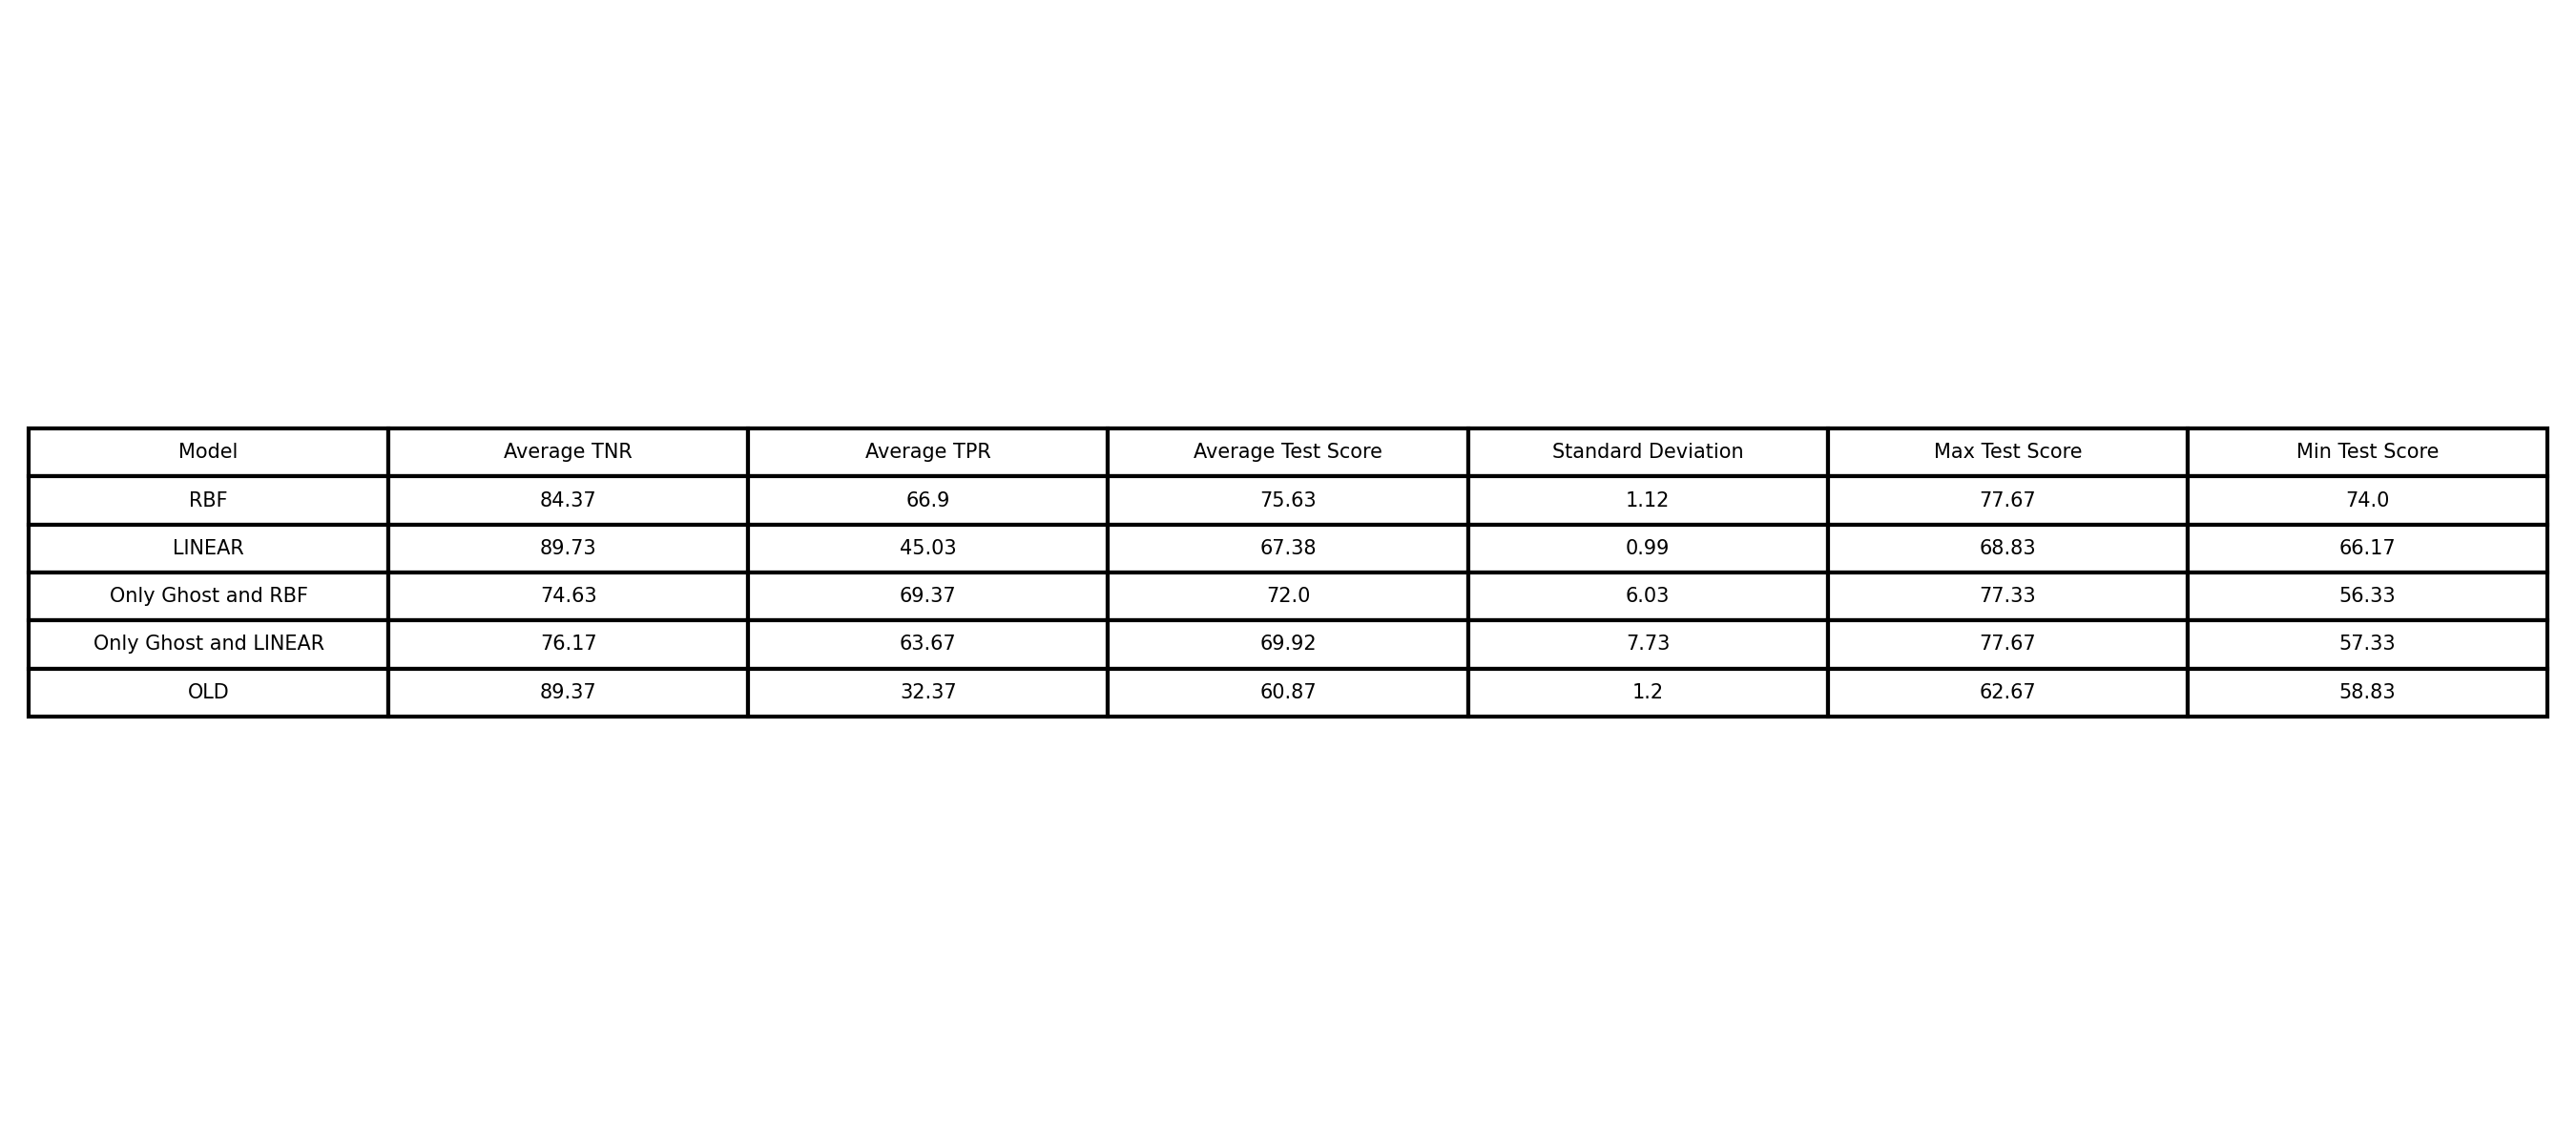

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 40
plt.rcParams["figure.figsize"] = (10.0, 5.0)
plt.rcParams["figure.dpi"] = 300

# DataFrameをMatplotlibでプロット
plt.axis('off')  # 軸を非表示にする
table = plt.table(cellText=statistics_df.values,
                  colLabels=statistics_df.columns,
                  cellLoc='center', rowLoc='center',
                  loc='center')  # 表の文字サイズを調整

plt.tight_layout()  # レイアウトを調整
plt.savefig('table7.png', bbox_inches="tight", pad_inches=0.0)
plt.show()